In [1]:

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization
from transformers import TFBertModel, BertTokenizer



tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = "English2TraChinese.txt"


with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
max_seq_len = 0
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))
    max_seq_len = max(max_seq_len, len(eng), len(spa))
print("max seq len:",max_seq_len )


for _ in range(5):
    print(random.choice(text_pairs))



random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")



strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = max_seq_len + 1 #20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)



def format_dataset(eng_id, eng_mask, spa):
    #eng_id = eng_vectorization(eng_id)
    #eng_mask = eng_vectorization(eng_mask)
    spa = spa_vectorization(spa)
    return (
        {
            "input_ids": eng_id,
            "attention_mask": eng_mask,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    eng_texts = tokenizer(eng_texts, return_tensors="tf", padding=True, truncation=True)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts["input_ids"],eng_texts["attention_mask"], spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)



for inputs, targets in train_ds.take(1):
    print(f'inputs["input_ids"].shape: {inputs["input_ids"].shape}')
    print(f'inputs["attention_mask"].shape: {inputs["attention_mask"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")





2025-05-12 01:47:16.963747: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 01:47:16.974640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746985636.987199   55470 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746985636.990728   55470 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-12 01:47:17.003684: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

max seq len: 121
('You are wanted on the phone.', '[start] 有你的電話。 [end]')
('How about you?', '[start] 您呢？ [end]')
('How did Tom get out of jail?', '[start] 湯姆是如何出獄的？ [end]')
('Call me at six tomorrow morning.', '[start] 明天早上6點給我打電話。 [end]')
('The girls were asleep.', '[start] 女孩們睡著了 [end]')
20132 total pairs
14094 training pairs
3019 validation pairs
3019 test pairs


I0000 00:00:1746985640.235378   55470 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13689 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


inputs["input_ids"].shape: (64, 42)
inputs["attention_mask"].shape: (64, 42)
inputs["decoder_inputs"].shape: (64, 122)
targets.shape: (64, 122)


2025-05-12 01:47:22.442689: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [2]:

import keras.ops as ops
from transformers import TFBertModel
from transformers import BertTokenizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
            padding_mask = ops.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config



from transformers import TFBertModel
from tensorflow import keras
import tensorflow as tf

embed_dim = 768
latent_dim = 2048
num_heads = 8

# Define model inputs
input_ids_in = keras.Input(shape=(None,), dtype="int32", name="input_ids")
attention_mask_in = keras.Input(shape=(None,), dtype="int32", name="attention_mask")

# Wrap BERT in a custom layer
class BertEncoder(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained("bert-base-chinese")
        self.bert.trainable = False  # ← Freeze BERT weights

    def call(self, inputs):
        ids, mask = inputs  # Rename to avoid conflict with outer scope
        outputs = self.bert(input_ids=ids, attention_mask=mask)
        return outputs.last_hidden_state

# Use the custom BERT layer
encoder_outputs = BertEncoder()([input_ids_in, attention_mask_in])

# Define encoder model
encoder = keras.Model(inputs=[input_ids_in, attention_mask_in], outputs=encoder_outputs)


'''
input_texts = ["你好，世界", "我喜欢学习"]
inputs_1 = tokenizer(input_texts, return_tensors="tf", padding=True, truncation=True)
#model.fit(
    x={"input_ids": inputs_1["input_ids"], "attention_mask": inputs_1["attention_mask"]},
    y=...
)
'''
#===============================================================================
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, 768), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [input_ids_in, attention_mask_in, decoder_inputs], decoder_outputs, name="transformer"
)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [3]:
epochs = 60

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_encoder        │ (None, None, 768) │          0 │ input_ids[0][0],  │
│ (BertEncoder)       │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, None,      │ 64,088,984 │ decoder_inputs[0… │
│ (Functional)        │ 15000)            │            │ bert_encoder[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 64,088,984 (244.48 MB)

 Trainable params: 64,088,984 (244.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60


I0000 00:00:1746985654.254791   55588 service.cc:148] XLA service 0x7f682400edd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746985654.254824   55588 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
W0000 00:00:1746985654.550181   55588 assert_op.cc:38] Ignoring Assert operator transformer_1/bert_encoder_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
2025-05-12 01:47:34.610635: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1746985655.082910   55588 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1746985655.760291   55588 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-12 01:47:37.227073: I external/local_xla/xla/stream_executor/cuda/c

 94/221 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 0.9319 - loss: 0.7854

W0000 00:00:1746985698.562301   55588 assert_op.cc:38] Ignoring Assert operator transformer_1/bert_encoder_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1746985698.881786   55588 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-05-12 01:48:20.759821: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44_0', 352 bytes spill stores, 216 bytes spill loads

2025-05-12 01:48:20.842060: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 32 bytes spill stores, 32 bytes spill loads

2025-05-12 01:48:20.919932: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fus

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9613 - loss: 0.4421

W0000 00:00:1746985746.404081   55584 assert_op.cc:38] Ignoring Assert operator transformer_1/bert_encoder_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1746985746.828252   55584 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-05-12 01:49:07.768545: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 352 bytes spill stores, 216 bytes spill loads

2025-05-12 01:49:07.810303: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 8 bytes spill stores, 8 bytes spill loads

2025-05-12 01:49:07.834386: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

221/221 ━━━━━━━━━━━━━━━━━━━━ 114s 391ms/step - accuracy: 0.9614 - loss: 0.4408 - val_accuracy: 0.9917 - val_loss: 0.0803
Epoch 2/60
221/221 ━━━━━━━━━━━━━━━━━━━━ 59s 266ms/step - accuracy: 0.9918 - loss: 0.0808 - val_accuracy: 0.9917 - val_loss: 0.0817
Epoch 3/60
221/221 ━━━━━━━━━━━━━━━━━━━━ 59s 267ms/step - accuracy: 0.9917 - loss: 0.0805 - val_accuracy: 0.9917 - val_loss: 0.0824
Epoch 4/60
221/221 ━━━━━━━━━━━━━━━━━━━━ 60s 270ms/step - accuracy: 0.9918 - loss: 0.0802 - val_accuracy: 0.9917 - val_loss: 0.0837
Epoch 5/60
221/221 ━━━━━━━━━━━━━━━━━━━━ 59s 268ms/step - accuracy: 0.9918 - loss: 0.0802 - val_accuracy: 0.9917 - val_loss: 0.0853
Epoch 6/60
221/221 ━━━━━━━━━━━━━━━━━━━━ 59s 268ms/step - accuracy: 0.9917 - loss: 0.0802 - val_accuracy: 0.9917 - val_loss: 0.0856
Epoch 7/60
221/221 ━━━━━━━━━━━━━━━━━━━━ 59s 267ms/step - accuracy: 0.9918 - loss: 0.0800 - val_accuracy: 0.9917 - val_loss: 0.0866
Epoch 8/60
221/221 ━━━━━━━━━━━━━━━━━━━━ 60s 270ms/step - accuracy: 0.9917 - loss: 0.0800 - va

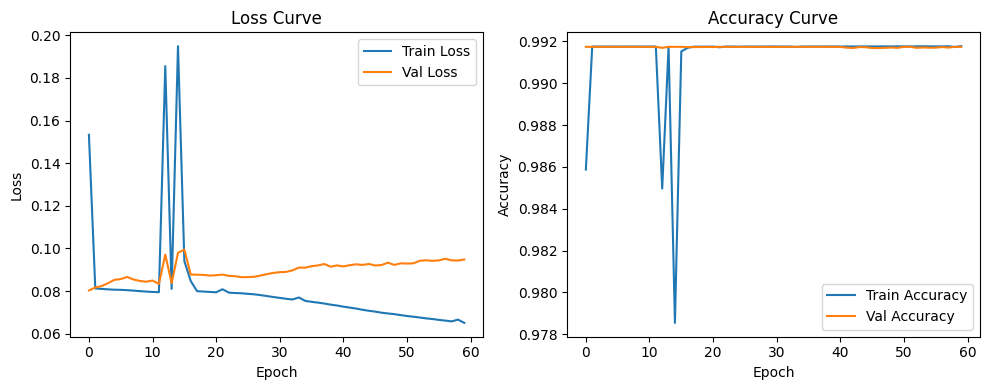

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:

spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized = tokenizer([input_sentence], return_tensors="tf", padding=True, truncation=True)
    input_ids = tokenized["input_ids"]
    attention_mask = tokenized["attention_mask"]

    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        # Convert the current decoded sentence to token IDs
        decoder_input_ids = spa_vectorization([decoded_sentence])  # Make sure this returns tensor shape (1, current_length)

        # Call transformer with the correct inputs
        predictions = transformer([input_ids, attention_mask, decoder_input_ids])

        sampled_token_index = tf.argmax(predictions[0, i, :]).numpy().item()
        sampled_token = spa_index_lookup[sampled_token_index]

        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    print(input_sentence)
    translated = decode_sequence(input_sentence)
    print(translated)

He has a large family to support.
[start] 你知道她是否會講英語嗎？ [end]
I should not have said that.
[start]                    
That just doesn't make sense to me.
[start] 我不知道我是否有時間做。 [end]
Money does not grow on trees.
[start] 我不知道我是否有時間做。 [end]
I just don't want to lose you.
[start] 我不知道，也不想知道。 [end]
Did Tom used to be a teacher?
[start] 我不知道，也不想知道。 [end]
I'm using Twitter.
[start]                    
You will fail.
[start] 你們好嗎？ [end]
Spring is the best season to visit Kyoto.
[start] 你們好嗎？ [end]
You can keep this one for yourself.
[start] 我不知道，也不想知道。 [end]
He sells cars.
[start] 你們好嗎？ [end]
I am from Shizuoka.
[start]                    
He said hello to the woman.
[start] 我不知道，也不想知道。 [end]
She wears a lot of makeup.
[start] 這本雜志不要扔。我還沒看呢。 [end]
You're not as smart as me.
[start]                    
I don't feel very well. I should go home.
[start] 你們好嗎？ [end]
I want to keep moving.
[start] 她現在忙，沒有辦法跟您說話。 [end]
I had to stay in bed all day.
[start]                    
Stick a notice on the b

In [6]:

spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized = tokenizer([input_sentence], return_tensors="tf", padding=True, truncation=True)
    input_ids = tokenized["input_ids"]
    attention_mask = tokenized["attention_mask"]

    decoded_sentence = ["[start]"]
    for _ in range(max_decoded_sentence_length):
        # 只用目前已生成的 token
        decoder_input = " ".join(decoded_sentence)
        decoder_input_ids = spa_vectorization([decoder_input])
        # 預測
        predictions = transformer([input_ids, attention_mask, decoder_input_ids])
        # 取最後一個 token 的預測
        sampled_token_index = tf.argmax(predictions[0, len(decoded_sentence)-1, :]).numpy().item()
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence.append(sampled_token)
        if sampled_token == "[end]":
            break
    # 去掉 [start] 和 [end]
    return " ".join(decoded_sentence[1:-1])


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    print(input_sentence)
    translated = decode_sequence(input_sentence)
    print(translated)

He has been to Hawaii several times.
你們好嗎？
I think his opinion is very important.
我好多天沒吃東西了。
I'm just looking.

I don't mind if I get wet.
                  
We're going to paint the wall.
你們好嗎？
I'm a stranger here myself. I'm afraid I can't help you.
她現在忙，沒有辦法跟您說話。
I belong to the drama club.
開始下雪了。
He heard a shout.
你們好嗎？
Why did you leave the class yesterday?
我不知道，也不想知道。
My father allowed me to go swimming.
我不知道我是否有時間做。
He is an Italian.
                  
Do you want to know what I see?
                  
There is no film in this camera.
                  
We expect a lot from him.
我不知道，也不想知道。
I had to go to America.
                  
Tom works in Boston.
                  
I don't think Tom is serious.
我好多天沒吃東西了。
These figures don't add up.
“你什麽時候回來？”“這都要看天氣。”
I feel bad enough already.
我好多天沒吃東西了。
Could you take this, please?
                  
There is an apple on the table.
你們好嗎？
Your work is below average.
去火車站要多久？
They came up with a plan after a long discussion.
我希望他會等我。
It'

In [ ]:

spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized = tokenizer([input_sentence], return_tensors="tf", padding=True, truncation=True)
    input_ids = tokenized["input_ids"]
    attention_mask = tokenized["attention_mask"]

    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        # Convert the current decoded sentence to token IDs
        decoder_input_ids = spa_vectorization([decoded_sentence])  # Make sure this returns tensor shape (1, current_length)

        # Call transformer with the correct inputs
        predictions = transformer([input_ids, attention_mask, decoder_input_ids])

        sampled_token_index = tf.argmax(predictions[0, i, :]).numpy().item()
        sampled_token = spa_index_lookup[sampled_token_index]

        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    print(input_sentence)
    translated = decode_sequence(input_sentence)
    print(translated)

He has a large family to support.
[start] 你知道她是否會講英語嗎？ [end]
I should not have said that.
[start]                    
That just doesn't make sense to me.
[start] 我不知道我是否有時間做。 [end]
Money does not grow on trees.
[start] 我不知道我是否有時間做。 [end]
I just don't want to lose you.
[start] 我不知道，也不想知道。 [end]
Did Tom used to be a teacher?
[start] 我不知道，也不想知道。 [end]
I'm using Twitter.
[start]                    
You will fail.
[start] 你們好嗎？ [end]
Spring is the best season to visit Kyoto.
[start] 你們好嗎？ [end]
You can keep this one for yourself.
[start] 我不知道，也不想知道。 [end]
He sells cars.
[start] 你們好嗎？ [end]
I am from Shizuoka.
[start]                    
He said hello to the woman.
[start] 我不知道，也不想知道。 [end]
She wears a lot of makeup.
[start] 這本雜志不要扔。我還沒看呢。 [end]
You're not as smart as me.
[start]                    
I don't feel very well. I should go home.
[start] 你們好嗎？ [end]
I want to keep moving.
[start] 她現在忙，沒有辦法跟您說話。 [end]
I had to stay in bed all day.
[start]                    
Stick a notice on the b

In [ ]:

spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized = tokenizer([input_sentence], return_tensors="tf", padding=True, truncation=True)
    input_ids = tokenized["input_ids"]
    attention_mask = tokenized["attention_mask"]

    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        # Convert the current decoded sentence to token IDs
        decoder_input_ids = spa_vectorization([decoded_sentence])  # Make sure this returns tensor shape (1, current_length)

        # Call transformer with the correct inputs
        predictions = transformer([input_ids, attention_mask, decoder_input_ids])

        sampled_token_index = tf.argmax(predictions[0, i, :]).numpy().item()
        sampled_token = spa_index_lookup[sampled_token_index]

        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    print(input_sentence)
    translated = decode_sequence(input_sentence)
    print(translated)

He has a large family to support.
[start] 你知道她是否會講英語嗎？ [end]
I should not have said that.
[start]                    
That just doesn't make sense to me.
[start] 我不知道我是否有時間做。 [end]
Money does not grow on trees.
[start] 我不知道我是否有時間做。 [end]
I just don't want to lose you.
[start] 我不知道，也不想知道。 [end]
Did Tom used to be a teacher?
[start] 我不知道，也不想知道。 [end]
I'm using Twitter.
[start]                    
You will fail.
[start] 你們好嗎？ [end]
Spring is the best season to visit Kyoto.
[start] 你們好嗎？ [end]
You can keep this one for yourself.
[start] 我不知道，也不想知道。 [end]
He sells cars.
[start] 你們好嗎？ [end]
I am from Shizuoka.
[start]                    
He said hello to the woman.
[start] 我不知道，也不想知道。 [end]
She wears a lot of makeup.
[start] 這本雜志不要扔。我還沒看呢。 [end]
You're not as smart as me.
[start]                    
I don't feel very well. I should go home.
[start] 你們好嗎？ [end]
I want to keep moving.
[start] 她現在忙，沒有辦法跟您說話。 [end]
I had to stay in bed all day.
[start]                    
Stick a notice on the b